In [94]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import dataset
admissions = pd.read_csv("/home/asus/Medoptix-Analytics/database/Dataset/admissions.csv")
metrics = pd.read_csv("/home/asus/Medoptix-Analytics/database/Dataset/daily_metrics.csv")
hospitals = pd.read_csv("/home/asus/Medoptix-Analytics/database/Dataset/hospitals.csv")
main_admissions = pd.read_csv("/home/asus/Medoptix-Analytics/database/Dataset/main_admissions.csv")
main_metrics = pd.read_csv("/home/asus/Medoptix-Analytics/database/Dataset/main_daily_metrics.csv")
wards = pd.read_csv("/home/asus/Medoptix-Analytics/database/Dataset/wards.csv")

# Merge datasets

In [4]:
admissions = pd.concat([admissions, main_admissions], ignore_index=True)
metrics = pd.concat([metrics, main_metrics], ignore_index=True)


In [8]:
list_data = [("admissions", admissions), ("metrics", metrics), ("hospitals", hospitals), ("wards", wards)]

for name, data in list_data:
    print(name)
    print(f"{round(data.isnull().mean() * 100, 2)}\n")

    print(data.duplicated().sum())

    print(data.describe())
    print(data.describe(include=("O", "category")))
    print("-"*100)

admissions
ï»¿admission_id        99.68
date                    0.00
hospital_id             0.00
ward_code               0.00
arrival_source          0.00
triage_level           68.63
wait_minutes            0.00
length_of_stay_days     0.00
outcome                 0.00
age                     0.00
sex                     0.00
procedure_flag          0.00
admission_id            0.32
dtype: float64

0
       ï»¿admission_id    hospital_id   wait_minutes  length_of_stay_days  \
count        545.00000  169276.000000  169276.000000        169276.000000   
mean         273.00000       2.861197     192.670266             3.026460   
std          157.47222       1.448333      75.111417             3.070374   
min            1.00000       1.000000     -15.000000            -5.000000   
25%          137.00000       2.000000     142.000000             0.000000   
50%          273.00000       3.000000     184.000000             2.000000   
75%          409.00000       4.000000     234.000000   

# Calculate Outlier using Empirical Rule
- mean
- standard deviation

lower = mean - (3 * standard deviation)

upper = mean + (3 * standard deviation)

*anything below the lower boundary is an outlier

*anything above the upper boundary is an outlier

In [20]:
for name, data in list_data:
    print(name)
    for col in data.select_dtypes(include="number").columns.to_list():
        mean = data[col].mean()
        std = data[col].std()
        lower_bound = mean - 3 * std
        upper_bound = mean + 3 * std

        outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]

        print(col)
        print(len(outliers))
        print('_'*50)


admissions
ï»¿admission_id
0
__________________________________________________
hospital_id
0
__________________________________________________
wait_minutes
1393
__________________________________________________
length_of_stay_days
918
__________________________________________________
age
230
__________________________________________________
procedure_flag
1
__________________________________________________
admission_id
0
__________________________________________________
metrics
hospital_id
0
__________________________________________________
base_beds
0
__________________________________________________
effective_capacity
0
__________________________________________________
occupancy
0
__________________________________________________
overflow
123
__________________________________________________
admissions
40
__________________________________________________
discharges
0
__________________________________________________
staffing_index
23
____________________________________

# drop irrelevant columns

In [66]:
cols_to_drop = ["ï»¿admission_id", "ï»¿date", "admission_id"]

for names, data in list_data:
    print(names)
    for col in cols_to_drop:
        if col in data.columns:
            data.drop(columns=col, axis=1, inplace=True)

admissions
metrics
hospitals
wards


# Fill Null Values 

In [57]:
values_to_replace = {
    "6.5": None,
    "abc": None
}
admissions["triage_level"].replace(values_to_replace, inplace=True)

In [78]:
cols_to_fill = ['date', 'triage_level']

for name, data in list_data:
    for col in cols_to_fill:
        if 'triage_level' in data.columns:
            data['triage_level'] = data.groupby('arrival_source')['triage_level'].transform(lambda x: x.fillna(x.mode()[0]))

        if 'date' in data.columns:
            data['date'] = pd.to_datetime(data['date'], errors = 'coerce')
            data['date'] = data['date'].fillna(method='ffill')
            data['date'] = data['date'].fillna(method='bfill')
            data['date'].interpolate()
            


# Handing Outliers with Winsorization Technique

In [62]:
for name, data in list_data:
    for col in data.select_dtypes(include="number").columns.to_list():

        lower_bound = data[col].quantile(0.05)
        upper_bound = data[col].quantile(0.95)

        data[col].clip(lower=lower_bound, upper=upper_bound, inplace=True)

In [63]:
for name, data in list_data:
    print(name)
    for col in data.select_dtypes(include="number").columns.to_list():
        mean = data[col].mean()
        std = data[col].std()
        lower_bound = mean - 3 * std
        upper_bound = mean + 3 * std

        outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]

        print(col)
        print(len(outliers))
        print('_'*50)


admissions
hospital_id
0
__________________________________________________
wait_minutes
0
__________________________________________________
length_of_stay_days
0
__________________________________________________
age
0
__________________________________________________
procedure_flag
0
__________________________________________________
admission_id
0
__________________________________________________
metrics
hospital_id
0
__________________________________________________
base_beds
0
__________________________________________________
effective_capacity
0
__________________________________________________
occupancy
0
__________________________________________________
overflow
0
__________________________________________________
admissions
0
__________________________________________________
discharges
0
__________________________________________________
staffing_index
0
__________________________________________________
avg_wait_minutes
0
______________________________________________

In [64]:
for name, data in list_data:
    for col in data.select_dtypes(include=['object', 'category']).columns.to_list():
        print(data[col].value_counts())
        print('-' * 50)

date
2022-11-18      180
2022-11-14      180
2022-11-11      180
2022-11-10      180
2022-12-11      180
               ... 
2025-07-08      139
2024-05-08      139
2025-09-13      137
2024-07-28      133
invalid-date      1
Name: count, Length: 1096, dtype: int64
--------------------------------------------------
ward_code
ED       53062
MED      43818
ICU      40814
SURG     31569
SURCG       13
Name: count, dtype: int64
--------------------------------------------------
arrival_source
self         101509
ambulance     30671
referral      25299
transfer      11797
Name: count, dtype: int64
--------------------------------------------------
triage_level
3.0     137240
4.0      15812
2.0       7897
5.0       5217
1.0       2566
3.0        214
4.0        155
2.0         76
5.0         69
1.0         28
Null         2
Name: count, dtype: int64
--------------------------------------------------
outcome
discharged     159360
readmit_30d      4451
transferred      4150
death            1314

In [67]:
admissions

,date,hospital_id,ward_code,arrival_source,triage_level,wait_minutes,length_of_stay_days,outcome,age,sex,procedure_flag
0,2022-10-28,1,ED,referral,4.0,189,0,discharged,48,M,0.0
1,2022-10-28,1,ICU,ambulance,4.0,189,0,transferred,86,F,0.0
2,2022-10-28,1,ED,self,3.0,189,0,discharged,52,M,0.0
3,2022-10-28,1,MED,self,3.0,189,0,discharged,64,M,0.0
4,2022-10-28,1,ED,self,4.0,189,0,discharged,59,M,0.0
...,...,...,...,...,...,...,...,...,...,...,...
169271,2024-03-17,5,SURG,self,3.0,104,1,discharged,65,F,1.0
169272,2024-03-17,5,SURG,self,3.0,104,3,discharged,60,F,1.0
169273,2024-03-17,5,SURG,self,3.0,104,5,readmit_30d,81,M,1.0
169274,2024-03-18,5,SURG,ambulance,3.0,105,3,discharged,65,M,1.0


In [79]:
metrics

,hospital_id,ward_code,base_beds,effective_capacity,occupancy,overflow,admissions,discharges,staffing_index,avg_wait_minutes,admission_rate_per_bed,discharge_rate_per_bed,occupancy_rate,date
0,1,MED,30,34,34,26,51,17,0.999,219,1.700,0.567,1.000,2022-10-28
1,1,SURCG,30,34,34,35,62,31,0.938,223,2.067,1.033,1.000,2022-10-28
2,1,ICU,30,34,34,39,63,28,0.953,275,2.100,0.933,1.000,2022-10-28
3,1,ED,30,34,34,26,56,33,0.974,227,1.867,1.100,1.000,2022-10-28
4,1,MED,30,34,34,29,55,30,1.013,257,1.833,1.000,1.000,2022-10-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21968,5,SURG,40,46,46,15,26,17,0.944,197,0.650,0.425,1.000,2025-10-22
21969,5,SURG,40,46,46,9,20,17,0.962,214,0.500,0.425,1.000,2025-10-23
21970,5,SURG,40,46,43,3,15,18,0.957,154,0.375,0.450,0.935,2025-10-24
21971,5,SURG,40,40,34,1,9,18,0.909,89,0.325,0.450,0.935,2025-10-25


In [69]:
wards

,hospital_id,ward_id,ward_code,ward_name,base_beds
0,1,01-ED,ED,Emergency Department,30
1,1,01-ICU,ICU,Intensive Care Unit,20
2,1,01-MED,MED,General Medicine,50
3,1,01-SURG,SURG,Surgery,40
4,2,02-ED,ED,Emergency Department,30
5,2,02-ICU,ICU,Intensive Care Unit,20
6,2,02-MED,MED,General Medicine,50
7,2,02-SURG,SURG,Surgery,40
8,3,03-ED,ED,Emergency Department,30
9,3,03-ICU,ICU,Intensive Care Unit,20


In [70]:
hospitals

,hospital_id,hospital_name,city,country,latitude,longitude,founded_year
0,1.2,Helsinki Central Hospital,Helsinki,Finland,63.66980,25.07210,1982.8
1,2.0,Tampere City Hospital,Tampere,Finland,63.28680,23.14178,2007.0
2,3.0,Turku University Hospital,Turku,Finland,64.47644,27.32800,1998.0
3,4.0,Oulu Regional Hospital,Oulu,Finland,60.68328,25.15270,2003.0
4,4.8,Kuopio Medical Center,Kuopio,Finland,61.65400,28.25552,2003.0


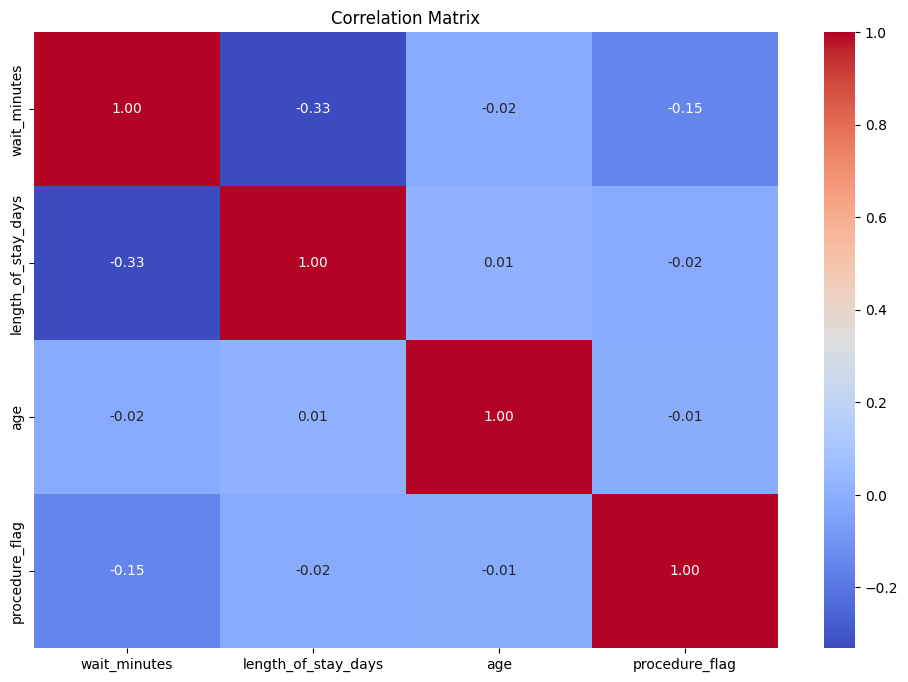

In [95]:
num_cols = admissions.select_dtypes(include='number').drop(columns=['hospital_id'])
corr = num_cols.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

#### Feature 1: wait_per_triage
**Purpose:** Measures how long each triage level waits, normalized by urgency  

**Formula:**  
`wait_minutes / triage_level`

**Rationale:**
- Triage 1 (most urgent) should wait less than Triage 5  
- A 200-minute wait for Triage 1 is worse than the same wait for Triage 5  
- Normalizing helps identify when urgent patients wait too long  

**Handling:**
1. Convert `triage_level` to numeric (invalid values → `NaN`)  
2. Clip outliers at the 95th percentile  
3. Fill `NaN` with median to maintain data integrity  

---

#### Feature 2: bed_impact_score
**Purpose:** Estimates how much hospital resources an admission will consume  

**Formula:**  
`length_of_stay_days × (1 + procedure_flag) × (6 - triage_level)`

**Rationale:**
- Longer stays → more bed days  
- Procedures increase resource consumption (multiplier effect)  
- Higher urgency (lower triage number) → more intensive care  
- Combined score predicts total resource demand  

**Example:**  
- **ICU patient:**  
  `5 days × (1 + 1 procedure) × (6 - 1 triage) = 50 points`  
- **ED patient:**  
  `0 days × (1 + 0) × (6 - 3) = 0 points`  


In [97]:
admissions['triage_level'] = pd.to_numeric(admissions['triage_level'], errors='coerce')
admissions['wait_per_triage'] = admissions['wait_minutes'] / admissions['triage_level']

admissions['wait_per_triage'] = admissions['wait_per_triage'].clip(lower=0, upper=admissions['wait_per_triage'].quantile(0.95))
admissions['wait_per_triage'] = admissions['wait_per_triage'].fillna(admissions['wait_per_triage'].median())

admissions['bed_impact_score'] = (
    admissions['length_of_stay_days'] * 
    (1 + admissions['procedure_flag']) *
    (6 - pd.to_numeric(admissions['triage_level'], errors='coerce'))
)


admissions.drop(columns=['triage_level', 'wait_minutes', 'length_of_stay_days', 'procedure_flag'], inplace=True)

In [98]:
admissions_agg = admissions.groupby(['date', 'hospital_id', 'ward_code']).agg({
    'wait_per_triage': 'mean',
    'age': 'mean',
    'bed_impact_score': 'mean'
}).reset_index()

categorical_cols = ['arrival_source', 'outcome', 'sex']

for col in categorical_cols:
    counts = (admissions.groupby(['date', 'hospital_id', 'ward_code', col])
              .size()
              .unstack(fill_value=0))
    counts.columns = [f'{col}_{c}' for c in counts.columns]
    admissions_agg = admissions_agg.merge(counts.reset_index(), 
                                          on=['date', 'hospital_id', 'ward_code'], 
                                          how='left')

admissions_agg

,date,hospital_id,ward_code,wait_per_triage,age,bed_impact_score,arrival_source_ambulance,arrival_source_referral,arrival_source_self,arrival_source_transfer,outcome_death,outcome_discharged,outcome_readmit_30d,outcome_transferred,outcome_unknown,sex_F,sex_M,sex_X
0,2022-10-28,1,ED,57.005263,52.315789,0.000,6,3,9,1,0,14,0,5,0,6,13,0
1,2022-10-28,1,ICU,34.225000,56.100000,15.000,2,0,7,1,0,9,0,1,0,4,6,0
2,2022-10-28,1,MED,37.425000,61.400000,12.600,2,1,7,0,0,10,0,0,0,4,6,0
3,2022-10-28,1,SURCG,53.291667,45.500000,0.000,1,1,0,0,0,0,0,2,0,1,1,0
4,2022-10-28,1,SURG,29.000000,61.000000,11.250,0,2,5,1,0,8,0,0,0,3,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19283,2025-10-26,4,MED,65.000000,55.500000,12.375,1,0,6,1,0,7,1,0,0,2,6,0
19284,2025-10-26,4,SURG,29.000000,47.750000,15.000,1,2,4,1,0,7,1,0,0,6,2,0
19285,2025-10-26,5,ED,71.581944,58.666667,0.000,2,2,8,0,0,12,0,0,0,5,7,0
19286,2025-10-26,5,ICU,46.666667,61.333333,22.500,0,0,3,3,0,6,0,0,0,4,2,0


### Preventing Data Leakage 

#### Why Lag Features? 
To predict today's admissions, we can only use information from **yesterday or earlier**.

### Lag Strategy
- **1-day lag:** Yesterday's metrics (captures recent trends)
- **7-day lag:** Last week's metrics (captures weekly patterns)

### Features to Lag

- `occupancy` → occupancy_lag1, occupancy_lag7
- `overflow` → overflow_lag1, overflow_lag7
- `discharges` → discharges_lag1, discharges_lag7
- `avg_wait_minutes` → avg_wait_lag1, avg_wait_lag7
- `occupancy_rate` → occupancy_rate_lag1, occupancy_rate_lag7
- `admission_rate_per_bed` → admission_rate_per_bed_lag1, admission_rate_per_bed_lag7


In [99]:
metrics = metrics.sort_values(['hospital_id', 'ward_code', 'date'])

lag_columns = ['occupancy', 'overflow', 'discharges', 'admission_rate_per_bed',
               'avg_wait_minutes', 'occupancy_rate']

for col in lag_columns:
    metrics[f'{col}_lag1'] = metrics.groupby(['hospital_id', 'ward_code'])[col].shift(1)
    metrics[f'{col}_lag7'] = metrics.groupby(['hospital_id', 'ward_code'])[col].shift(7)
    

metrics_safe = metrics.drop(columns=lag_columns)
metrics = metrics_safe.dropna()

In [101]:
main_data = pd.merge(admissions_agg, metrics, on=['date', 'hospital_id', 'ward_code'], how='inner')
main_data.to_csv(r"cleaned_data.csv", index=False)